# 1. Setup

In [1]:
# !pip3 install pandas
# !pip3 install numpy
# !pip3 install seaborn
# !pip3 install pyspark

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

# import pandasql as ps
# from pandasql import sqldf

warnings.filterwarnings("ignore")

run this cell to generate a randomly sampled dataset (just run once)

In [ ]:
# file_path = './new_to_brand.tsv'

# df = pd.DataFrame()
# i = 0

# for chunk in pd.read_csv(file_path, sep='\t', chunksize=1000000):
#     i = 0
#     while i <= 5:
#         start = time.time()
#         df = pd.concat([df, chunk], ignore_index=True)
#         end = time.time()
#         print('-' * 20 + f'{i} iteration(s)' + '-' * 20)
#         print(f'in {end-start:.2f} seconds')
#         i+=1
#     break


# data wrangling
# # date
# df['order_datetime'] = pd.to_datetime(df['order_datetime'], format='mixed')

# # id
# ids = ['customer_id', 'seller_of_record_vendor_id']
# for col in ids:
#   s = pd.to_numeric(df[col], errors='coerce')
#   df[col] = s.apply(lambda x: f"{x:.0f}")


# create a sampler sample size
# df2 = df.sample(1000000)[
#     ['dama_mfg_vendor_code', 'asin', 'customer_id', 'order_datetime','order_item_level_condition']
# ]

# df2.to_csv('./new_to_brand_subset.tsv')

In [38]:
df2 = pd.read_csv('./new_to_brand_subset.tsv')

# 2. Spark Query

In [20]:
# Creating a spark context class
# sc = SparkContext() # only run this once

# create a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# create a spark df
sdf = spark.createDataFrame(df2)

# spark.catalog.dropTempView("orders") # drop view if exists

# create a temp table view
sdf.createTempView("orders")


In [111]:
query = '''
with cte1 as (
  select
    dama_mfg_vendor_code, asin, customer_id, order_datetime,
      dense_rank() over(partition by dama_mfg_vendor_code, customer_id order by order_datetime asc) as rn,
      lag(order_datetime) over(partition by dama_mfg_vendor_code, customer_id order by order_datetime) as last_purchase_date,
      lag(asin) over(partition by dama_mfg_vendor_code, customer_id order by order_datetime) as last_purchase_asin
  from orders
  where dama_mfg_vendor_code != 'NaN'
    and order_item_level_condition != 6
),
cte2 as (
  select
    asin, dama_mfg_vendor_code, customer_id, order_datetime,
    last_purchase_asin,
    last_purchase_date,
    (
      case
      when last_purchase_date is null
      then 'new to brand' 
      when extract(day from order_datetime - last_purchase_date)<= 30
      then '1 mo'
      when extract(day from order_datetime - last_purchase_date)> 30
        and extract(day from order_datetime - last_purchase_date)<= 60
      then '2 mo'
      when extract(day from order_datetime - last_purchase_date)> 60
        and extract(day from order_datetime - last_purchase_date) <= 90
      then '3 mo'
      when extract(day from order_datetime - last_purchase_date) > 90 
      then '> 3 mo'
      else '/'
      end
    ) as last_purchase_n_days_ago
  from cte1
)

select
  dama_mfg_vendor_code, asin, order_datetime,
  last_purchase_asin, last_purchase_date,
  last_purchase_n_days_ago,
  count(distinct customer_id) as unique_customer_ct
from cte2
where last_purchase_date is null
  OR extract(day from order_datetime) - extract(day from last_purchase_date) > 1
group by dama_mfg_vendor_code, asin,  last_purchase_n_days_ago, order_datetime, last_purchase_asin, last_purchase_date
order by dama_mfg_vendor_code, asin,  last_purchase_n_days_ago asc
'''

# spark.sql(query).show()
res = spark.sql(query).toPandas()
res

25/02/20 18:43:20 WARN TaskSetManager: Stage 143 contains a task of very large size (5940 KiB). The maximum recommended task size is 1000 KiB.


,dama_mfg_vendor_code,asin,order_datetime,last_purchase_asin,last_purchase_date,last_purchase_n_days_ago,unique_customer_ct
0,010AY,B0CP9ZVR92,2024-03-05 19:37:50,None,NaT,new to brand,1
1,013JZ,B07QYJVHLQ,2024-01-28 19:57:47,None,NaT,new to brand,1
2,0188E,B013WUE9VA,2024-01-28 07:18:49,None,NaT,new to brand,1
3,0188E,B013WUE9VA,2024-01-16 12:56:25,None,NaT,new to brand,1
4,0188E,B013WUE9VA,2024-03-13 07:02:47,None,NaT,new to brand,1
...,...,...,...,...,...,...,...
536603,ZZHYZ,B0891BPGGD,2024-01-02 16:18:38,None,NaT,new to brand,1
536604,ZZHYZ,B0891BPGGD,2024-03-07 12:37:16,None,NaT,new to brand,1
536605,ZZHYZ,B0891BPGGD,2024-04-03 20:49:11,None,NaT,new to brand,1
536606,ZZHYZ,B0891BPGGD,2024-02-07 13:38:30,None,NaT,new to brand,1


# 3. Demos

## 3.1 ASIN-Level

using vendor code UNJ1X as an example

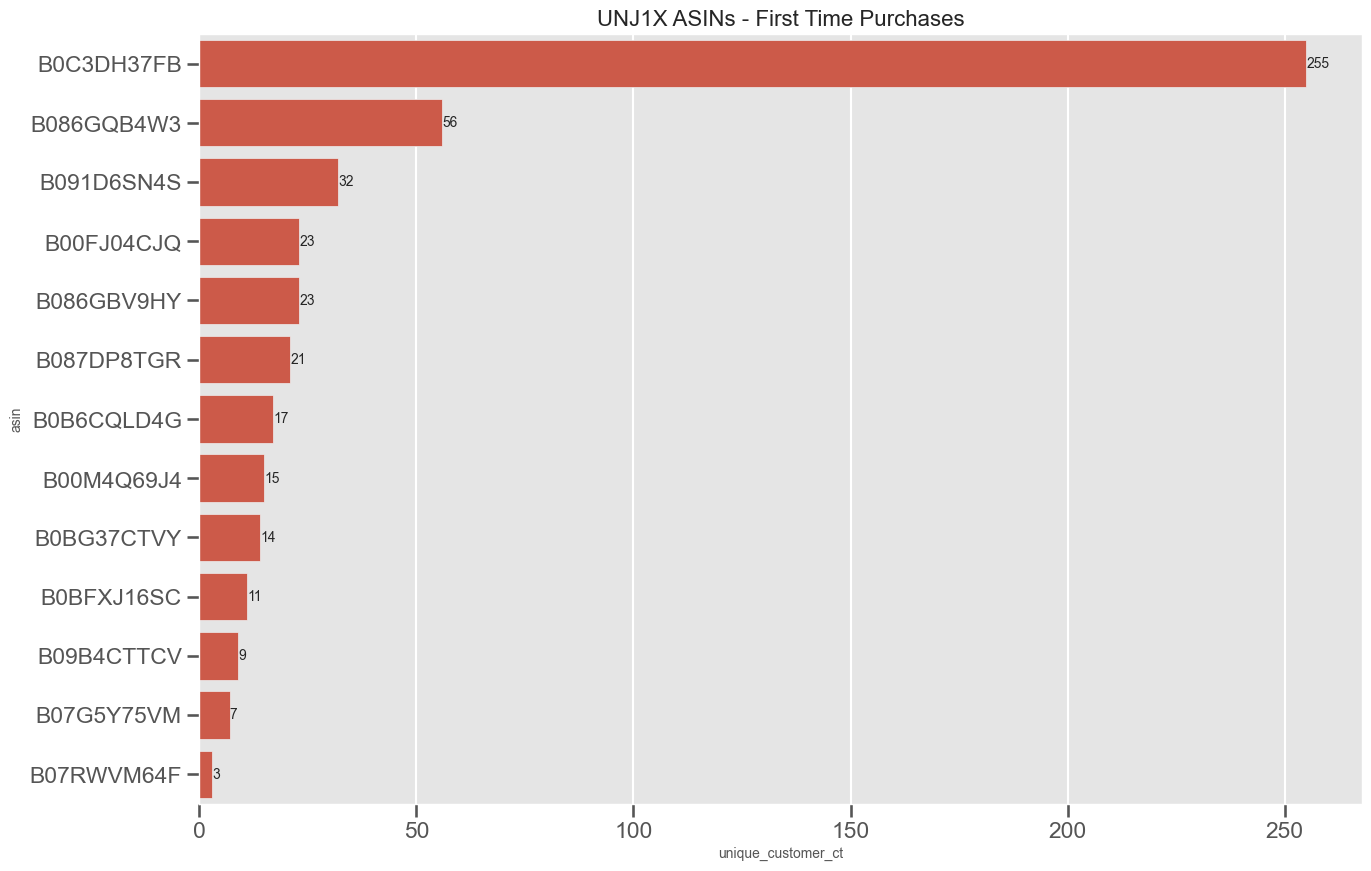

In [160]:
vendor_code='UNJ1X'
tmp = res[res['dama_mfg_vendor_code']==vendor_code]
tmp_asin_new = tmp[
    (tmp['last_purchase_n_days_ago'] == 'new to brand')
][['asin', 'unique_customer_ct']].groupby('asin').sum().sort_values(by='unique_customer_ct',ascending=False).reset_index()

# plot
sns.set(style="ticks", context="talk", rc = {'figure.figsize':(15,10)})
plt.style.use("ggplot")

ax = sns.barplot(
  tmp_asin_new,
  x='unique_customer_ct',
  y='asin'
)

# title
ax.set_title(f'{vendor_code} ASINs - First Time Purchases', fontsize=16) 
ax.bar_label(ax.containers[0])
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)

## 3.2 Company Level

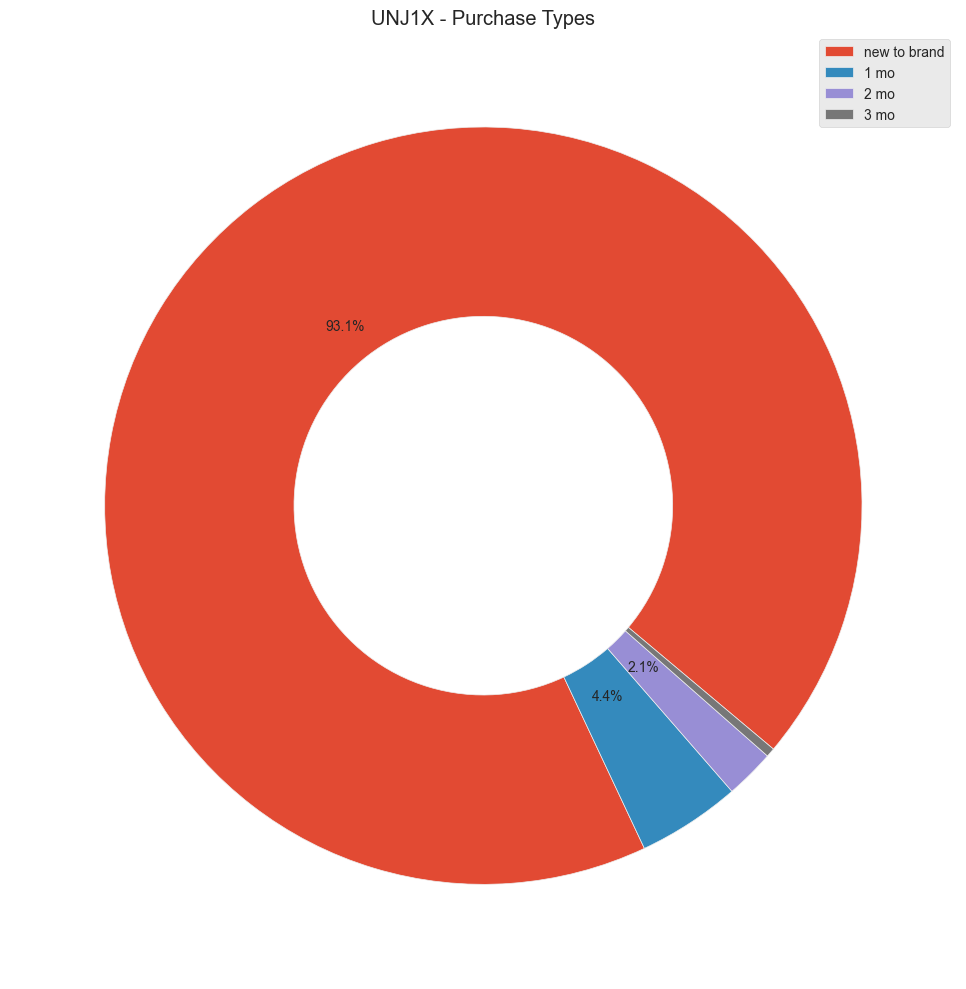

In [192]:

sns.set(style="ticks", context="talk", rc = {'figure.figsize':(15,10)})
plt.style.use("ggplot")

fig, ax = plt.subplots( subplot_kw=dict(aspect="equal"))
labels = tmp_retention_acq['last_purchase_n_days_ago']
data = tmp_retention_acq['unique_customer_ct']

wedges, texts,autotexts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40,autopct='%1.1f%%',)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < 2:
        label.set_text('')
        pct_label.set_text('')

ax.legend(wedges, labels, loc='upper right',fontsize=10)
ax.set_title(f"{vendor_code} - Purchase Types")
fig.tight_layout()